In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [10]:
import gzip
import os
import pickle
import platform

import cv2
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.misc import imread

from common import * 
import preprocess
import model_io

# Base Model

The full inception model is too slow for real time use on my laptop, so I am just using the first few layers.

Loading the whole inception model is also very slow, so cut out only the weights we need and save them for loading later.

In [3]:
import inception
import model_io

if not os.path.exists(BASE_MODEL_JSON_FILE):
    model_io.save_model(
        BASE_MODEL_JSON_FILE,
        BASE_MODEL_WEIGHTS_FILE,
        inception.make_cut_model())

In [4]:
model_io.load_base_model().summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 160, 320, 3)   0                                            
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 79, 159, 32)   896         input_1[0][0]                    
____________________________________________________________________________________________________
batchnormalization_1 (BatchNorma (None, 79, 159, 32)   64          convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 77, 157, 32)   9248        batchnormalization_1[0][0]       
___________________________________________________________________________________________

# Preprocessing

- Correct the image file paths, since I have several driving logs in different folders.
- Smooth the control inputs. The input from me is quite spikey, because all I can do is press a button or not. This seems like it would make learning quite difficult, so apply smoothing.
- Bottleneck the features to make training reasonably fast.

In [29]:
log = pd.concat([
    preprocess.run('data/ccw_1'),
    preprocess.run('data/cw_1')
])
print(log.head())

Bottleneck folder exists in data/ccw_1 ; just binding.
Bottleneck folder exists in data/cw_1 ; just binding.
                                        center_image  \
0  data/ccw_1/IMG/center_2016_12_08_21_38_10_346.jpg   
1  data/ccw_1/IMG/center_2016_12_08_21_38_10_462.jpg   
2  data/ccw_1/IMG/center_2016_12_08_21_38_10_578.jpg   
3  data/ccw_1/IMG/center_2016_12_08_21_38_10_678.jpg   
4  data/ccw_1/IMG/center_2016_12_08_21_38_10_779.jpg   

                                        left_image  \
0  data/ccw_1/IMG/left_2016_12_08_21_38_10_346.jpg   
1  data/ccw_1/IMG/left_2016_12_08_21_38_10_462.jpg   
2  data/ccw_1/IMG/left_2016_12_08_21_38_10_578.jpg   
3  data/ccw_1/IMG/left_2016_12_08_21_38_10_678.jpg   
4  data/ccw_1/IMG/left_2016_12_08_21_38_10_779.jpg   

                                        right_image  steering_angle  throttle  \
0  data/ccw_1/IMG/right_2016_12_08_21_38_10_346.jpg             0.0       0.0   
1  data/ccw_1/IMG/right_2016_12_08_21_38_10_462.jpg             0.0

## Smoothing

I tried two types of smoothing:

- Exponential smoothing: an exponential weighted moving average
- Gaussian smoothing: a 1D gaussian filter

Both seem to track pretty well, but the gaussian smoothing is better at preserving the mean steering angle.

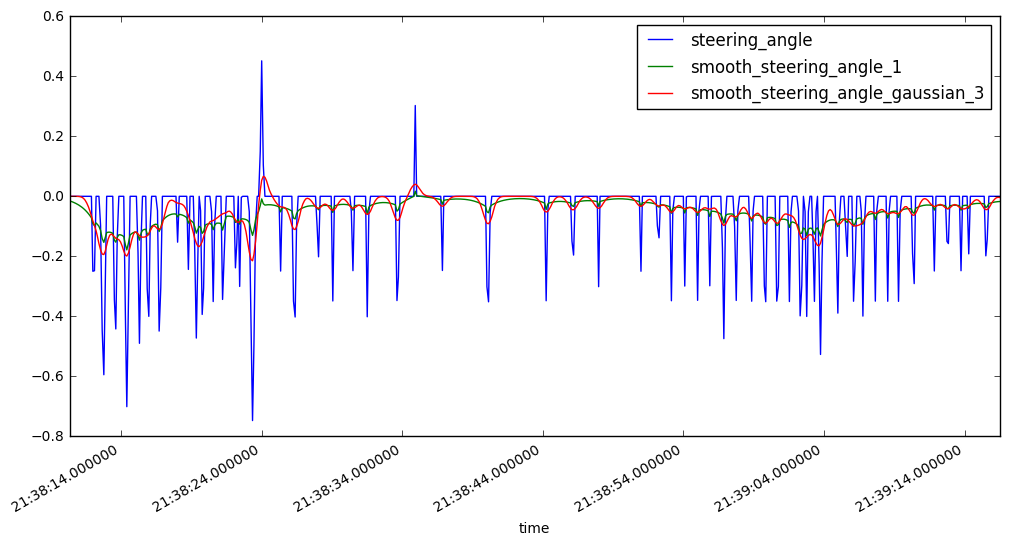

In [30]:
def plot_smooth_steering_angle():
    df = log[['time', 'steering_angle', 'smooth_steering_angle_1', 'smooth_steering_angle_gaussian_3']]
    df = df[:600]
    df = df.set_index(['time'])
    df.plot(figsize=(12, 6))
plot_smooth_steering_angle()

## Steering Angle Bias

We don't want a lot of bias in the training data. Or maybe this isn't that important... I don't really know.

In [7]:
print('raw steering angle bias:', np.mean(log['steering_angle']))
print('exponentially smoothed steering angle bias:', np.mean(log['smooth_steering_angle_1']))
print('gaussian smoothed steering angle bias:', np.mean(log['smooth_steering_angle_gaussian_5']))

raw steering angle bias: -0.018797702581490154
exponentially smoothed steering angle bias: -0.018680148301909304
gaussian smoothed steering angle bias: -0.018797702581490116


## Bottleneck Features

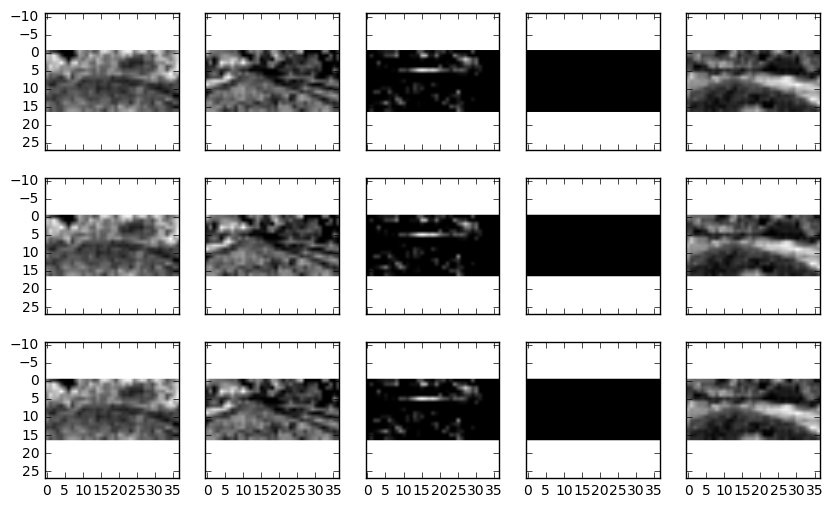

In [8]:
def plot_bottleneck_output(num_images, num_channels, image_stride=50):
    fig, axes = plt.subplots(num_images, num_channels,
                             figsize=(2*num_channels, 2*num_images),
                             sharex=True, sharey=True)
    for i in range(num_images):
        for j in range(num_channels):
            index = i * image_stride
            image = np.load(log['bottleneck_features'].values[i])['center_image']
            axes[i][j].imshow(image[:,:,j], cmap='gray')
plot_bottleneck_output(3,5)

## Smoothed Steering Video

In [11]:
def steering_angle_to_radians(steering_angle):
    """
    The recorded steering angle ranges from -1 to 1.
    In the sim, it gives values from -20 degrees to 20 degrees.
    """
    return math.radians(steering_angle * 20.0)

def draw_steering_angle(image, steering_angle, color, thickness=2):
    bottom_x = image.shape[1] / 2.0
    bottom_y = image.shape[0]
    radius = bottom_y / 2.0
    steering_angle_radians = steering_angle_to_radians(steering_angle)
    top_x = bottom_x + radius * math.sin(steering_angle_radians)
    top_y = bottom_y - radius * math.cos(steering_angle_radians)
    bottom_x, bottom_y = int(round(bottom_x)), int(round(bottom_y))
    top_x, top_y = int(round(top_x)), int(round(top_y))
    cv2.line(image, (bottom_x, bottom_y), (top_x, top_y), color, thickness)

def make_steering_movie(
    filestem,
    log,
    smoothed_steering_angle_column,
    predicted_steering_angle_column=None):
    
    if platform.system() == 'Linux':
        fourcc = cv2.VideoWriter_fourcc(*'MJPG')
        filename = filestem + '.avi'
    else:
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')        
        filename = filestemp + '.mp4'
    
    input_color = [0, 0, 255]
    smoothed_color = [0, 255, 0]
    predicted_color = [255, 0, 0]
    video = cv2.VideoWriter(filename, fourcc, 10, IMAGE_SHAPE[0:2][::-1])
    for i in range(len(log)):
        if i % 50 == 0:
            print('frame', i)
        image = imread(log['center_image'].values[i])
        steering_angle = log['steering_angle'].values[i]
        draw_steering_angle(image, steering_angle, input_color)

        smoothed_steering_angle = log[smoothed_steering_angle_column].values[i]
        draw_steering_angle(image, smoothed_steering_angle, smoothed_color)
        
        if predicted_steering_angle_column is not None:
            predicted_steering_angle = log[predicted_steering_angle_column].values[i]
            draw_steering_angle(image, predicted_steering_angle, predicted_color)
            
        video.write(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    video.release()

make_steering_movie('test', log[0:200], 'smooth_steering_angle_1')

frame 0
frame 50
frame 100
frame 150


# Model

In [12]:
import model

In [33]:
steering_model = model.build(
    input_shape=np.load(log['bottleneck_features'].values[0])['center_image'].shape
)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_2 (Convolution2D)  (None, 17, 37, 64)    16448       convolution2d_input_2[0][0]      
____________________________________________________________________________________________________
flatten_2 (Flatten)              (None, 40256)         0           convolution2d_2[0][0]            
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 1)             40257       flatten_2[0][0]                  
Total params: 56705
____________________________________________________________________________________________________


In [34]:
model.train(steering_model, log, nb_epoch=20, side_camera_bias=0.05, label_column='smooth_steering_angle_gaussian_3')

Epoch 1/20
5121/5121 [==============================] - 19s - loss: 0.3636 - val_loss: 0.0376
Epoch 2/20
5121/5121 [==============================] - 17s - loss: 0.0687 - val_loss: 0.0194
Epoch 3/20
5121/5121 [==============================] - 18s - loss: 0.0335 - val_loss: 0.0100
Epoch 4/20
5121/5121 [==============================] - 17s - loss: 0.0338 - val_loss: 0.0166
Epoch 5/20
5121/5121 [==============================] - 17s - loss: 0.0251 - val_loss: 0.0056
Epoch 6/20
5121/5121 [==============================] - 18s - loss: 0.0193 - val_loss: 0.0062
Epoch 7/20
5121/5121 [==============================] - 17s - loss: 0.0192 - val_loss: 0.0069


In [35]:
model_io.save_model('model.json', 'model.h5', steering_model)

In [24]:
log['predicted_steering_angle'] = steering_model.predict_generator(
    model.generate_data(log),
    val_samples=len(log)
).flatten()

In [25]:
make_steering_movie('test', log[0:500], 'smooth_steering_angle_1', 'predicted_steering_angle')

frame 0
frame 50
frame 100
frame 150
frame 200
frame 250
frame 300
frame 350
frame 400
frame 450


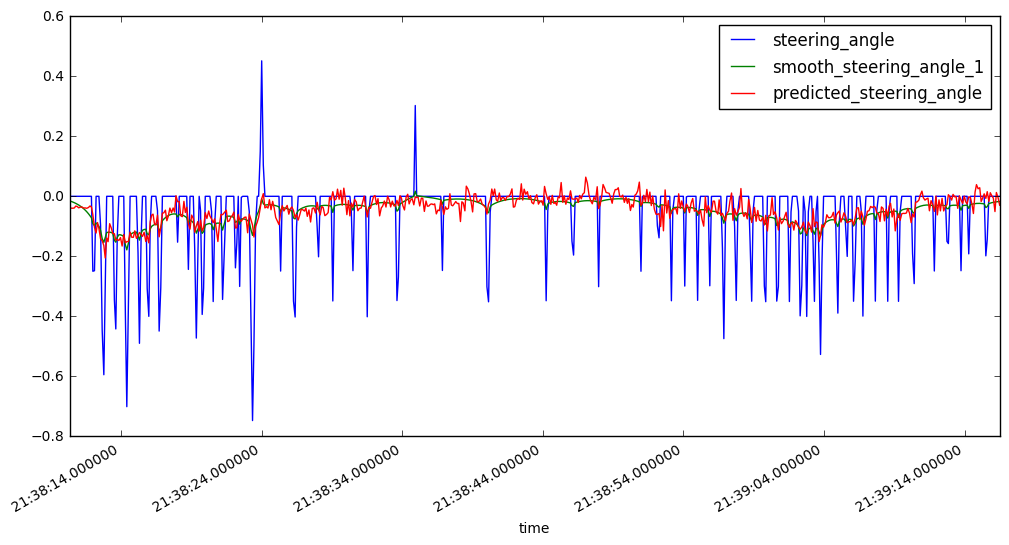

In [26]:
def plot_predicted_steering_angle():
    df = log[['time', 'steering_angle', 'smooth_steering_angle_1', 'predicted_steering_angle']]
    df = df[:600]
    df = df.set_index(['time'])
    df.plot(figsize=(12, 6))
plot_predicted_steering_angle()

In [36]:
# From http://stackoverflow.com/a/40623158/2053820
def dict_product(dicts):
    """
    >>> list(dict_product(dict(number=[1,2], character='ab')))
    [{'character': 'a', 'number': 1},
     {'character': 'a', 'number': 2},
     {'character': 'b', 'number': 1},
     {'character': 'b', 'number': 2}]
    """
    return (dict(zip(dicts, x)) for x in itertools.product(*dicts.values()))

In [ ]:
# def search_deep_hyperparameters():
#     results_file = 'search_deep_hyperparameters.pickle'
#     if os.path.isfile(results_file):
#         with open(results_file, 'rb') as f:
#             results = pickle.load(f)
#     else:
#         results = {}
    
#     keys = {
#         'version': [1],
#         'relu_count': [360],
#         'learning_rate': [0.1],
#         'max_epochs': [300],
#         'max_down_epochs': [10],
#         'batch_size': [128],
#         'initial_bias': [0.1],
#         'l2_weight': [0.001]}
        
#     for key in dict_product(keys):
#         print(key)
#         frozen_key = frozenset(key.items())
#         if frozen_key in results:
#             continue
#         print('Running...')
        
#         key = key.copy()
#         del key['version']
#         best_validation_accuracy, _ = \
#             train_deep(
#                 key.pop('learning_rate'),
#                 key.pop('max_epochs'),
#                 key.pop('max_down_epochs'),
#                 key.pop('batch_size'),
#                 key.pop('l2_weight'),
#                 key)
            
#         results[frozen_key] = { 'accuracy': best_validation_accuracy }
        
#         with open(results_file, 'wb') as f:
#             pickle.dump(results, f, pickle.HIGHEST_PROTOCOL)

#     return results  

# deep_grid = search_deep_hyperparameters()

TODO

- capture cw_2 and ccw_2 and combine those, too